Now that we've got SBert with label training going, this assesses the current trained model and tries some query and lemma pairs to see the similarity scores

To compare against other vector based baselines, see 220707_lemma_retrieval_exps

In [1]:
from setup_queries import *
from coprover.utils import ensure_numpy

766 9206
Lemma queries cached, loading


100%|█████████████████████████████████████████████████████████████████████| 766/766 [00:02<00:00, 286.49it/s]


# train=12132, test=8089, total=20221
10000/100000
20000/100000
30000/100000
40000/100000
50000/100000
60000/100000
70000/100000
80000/100000
90000/100000
100000/100000
10/100
20/100
30/100
40/100
50/100
60/100
70/100
80/100
90/100
100/100


In [2]:
from theorybank import PVSLIB_ROOT
for x in PVSLIB_ROOT.glob("*/"):print(x)

/home/fennel2/yeh/proj/CoProver/src/coprover/../../data/pvs/pvslib/vect_analysis
/home/fennel2/yeh/proj/CoProver/src/coprover/../../data/pvs/pvslib/vectors
/home/fennel2/yeh/proj/CoProver/src/coprover/../../data/pvs/pvslib/series
/home/fennel2/yeh/proj/CoProver/src/coprover/../../data/pvs/pvslib/ints
/home/fennel2/yeh/proj/CoProver/src/coprover/../../data/pvs/pvslib/numbers
/home/fennel2/yeh/proj/CoProver/src/coprover/../../data/pvs/pvslib/sigma_set
/home/fennel2/yeh/proj/CoProver/src/coprover/../../data/pvs/pvslib/reals
/home/fennel2/yeh/proj/CoProver/src/coprover/../../data/pvs/pvslib/algebra
/home/fennel2/yeh/proj/CoProver/src/coprover/../../data/pvs/pvslib/orders
/home/fennel2/yeh/proj/CoProver/src/coprover/../../data/pvs/pvslib/structures
/home/fennel2/yeh/proj/CoProver/src/coprover/../../data/pvs/pvslib/analysis
/home/fennel2/yeh/proj/CoProver/src/coprover/../../data/pvs/pvslib/sets_aux


In [19]:
from sentence_transformers import SentenceTransformer

# MODEL_FPATH = 'outputs/nir_sbert.220826/436400' # Old model, trained and test same lemmas
MODEL_FPATH = "outputs/nir_sbert/90000"  # Train and test proper separation

model = SentenceTransformer(MODEL_FPATH)


In [20]:

def scan(example):
    X = model.encode(example.texts)
    return X[0].dot(X[1])

In [29]:
test_examples[31].texts

['current-goal antecedents null consequents new? null formula operator deriv_real_vect2__derivable_rvp argument bindings subtype expression asserted? null new? null formula operator deriv_real_vect2__derivable_rvp argument bindings subtype expression operator vectors_2D__times__2 argument subtype asserted? null hidden null',
 'bindings variableName n expression operator notequal__notequal__1 constantName notequal__notequal__1 argument operator triangle_numbers__Tri constantName triangle_numbers__Tri argument operator number_fields__plus constantName number_fields__plus argument variableName n integerValue 1 integerValue 0']

In [22]:
pos_scores = []
neg_scores = []

for i in range(0,len(test_examples), 2):
    pos_score = scan(test_examples[i])
    neg_score = scan(test_examples[i+1])
    pos_scores.append(pos_score)
    neg_scores.append(neg_score)
    print(pos_score, neg_score)
    
print(np.mean(pos_scores), np.std(pos_scores))
print(np.mean(neg_scores), np.std(neg_scores))

698.0336 1.8749456
722.8218 -5.3675985
713.9838 1.0453377
711.7249 -12.207712
701.72095 2.6952934
649.6725 22.773071
698.204 -28.309057
701.41345 -23.888834
708.35284 14.790977
673.62744 -22.042747
722.6344 -22.895771
704.41675 2.9650168
717.7091 11.239952
699.8699 8.958073
714.88086 -0.74592304
682.09436 9.878852
708.4104 -10.445741
684.4858 -0.8546219
703.35925 5.3874836
724.8972 28.870218
692.18964 9.764464
725.5664 -2.608736
696.90497 -6.960911
661.8612 10.097407
712.5636 4.838881
714.181 -20.615276
691.87177 11.483585
689.8466 3.983642
679.9013 -20.848385
724.4712 -13.866255
681.91705 -31.90364
702.2228 20.118378
710.69446 2.6748352
739.99536 -6.612355
707.54474 -5.1188326
640.49194 -6.0306396
660.41003 5.4664707
74.94026 -18.500835
731.7728 -7.2547417
686.1853 10.682558
694.6893 251.24255
726.90314 9.920337
307.7796 9.524148
691.89 11.507908
680.724 -0.75217867
727.219 -63.28762
692.6244 5.6724706
708.8489 -4.68594
706.1438 4.8475733
716.5559 -36.24936
680.42444 104.5339
2.205014

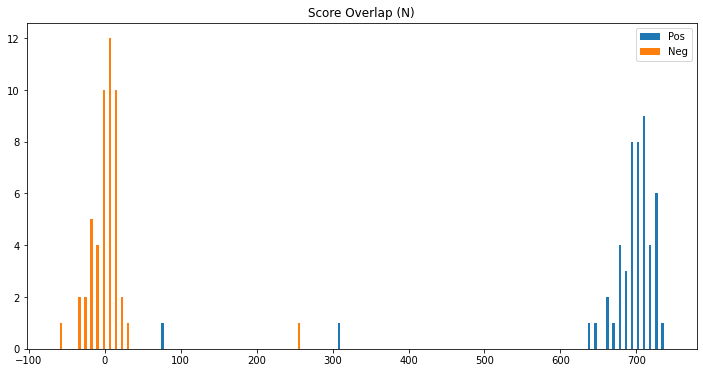

In [23]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(12,6))
ax.hist([pos_scores, neg_scores], label=["Pos", "Neg"], bins=100)
plt.title("Score Overlap (N)")
plt.legend()

In [24]:
# Attempt to vectorize all lemmas in theory
all_lemma_texts = []
for lemma in all_lemmas:
    all_lemma_texts.append(" ".join([str(x) for x in lemma]))

# Encode the entire library of lemmas into a single array
L = []
for i in tqdm(range(len(all_lemma_texts))):
    L.append(ensure_numpy(model.encode(all_lemma_texts[i])))
L = np.array(L)

100%|████████████████████████████████████████████████████████████████████| 8962/8962 [02:39<00:00, 56.24it/s]


In [45]:
#def query(query_text, L):
ranks = []
APPLY_NORM = True

L_normed = L / np.linalg.norm(L, axis=1).reshape((len(L), 1))

for qidx in tqdm(range(len(test_queries))):
    test_query = test_queries[qidx]
    query_gold = test_query['name']
    if query_gold in all_lemma_names:
        query_text = " ".join([str(x) for x in test_query['state']])
        q = ensure_numpy(model.encode(query_text))
        if APPLY_NORM:
            q = q / np.linalg.norm(q)
            scored = L_normed.dot(q)
        else:
            scored = L.dot(q)
        matches = np.argsort(scored)
        guess_rank = None

        for rank, idx in enumerate(matches[::-1]):
            score = scored[idx]
            guess_name = all_lemma_names[idx]
            # print(rank + 1, idx, score, all_lemma_names[idx], len(all_lemmas[idx]))
            if guess_name == query_gold:
                guess_rank = rank + 1
                ranks.append(guess_rank)
                break
    else:
        pass

100%|████████████████████████████████████████████████████████████████████| 8089/8089 [04:01<00:00, 33.47it/s]


In [46]:
def mrr(ranks):
    N = len(ranks)
    return sum([1/r for r in ranks]) / N
    

In [47]:
res_mrr = mrr(ranks)
print("MRR = {:.3f}".format(res_mrr))
print("Rank pos={:.3f}".format(1 / mrr(ranks)))

MRR = 0.505
Rank pos=1.982


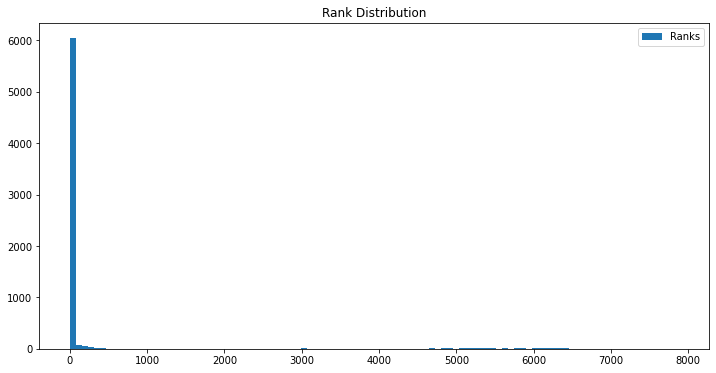

In [28]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(12,6))
ax.hist([ranks], label=["Ranks"], bins=100)
plt.title("Rank Distribution")
plt.legend()

In [18]:
np.sum(np.array(ranks) == 1) / len(ranks)

0.3352645220307974

In [16]:
len (ranks)

6559